**Description:** This notebook is used to play a business case based on fictional data. 

**Project Name:** Supervised Learning Model Comparison Project: Finding Donors for *CharityML*

**Author:** Silas Mederer

**Date:** 2020-10-18

# Supervised Learning Project: Finding Donors for *CharityML*


In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import functions from own Python-File
import visuals as vs
import eda_methods as eda

# Pretty display for notebooks
%matplotlib inline

# warnings handler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the Census dataset
df = pd.read_csv("data/census.csv")

# Success - Display the first record
df.head().T

,0,1,2,3,4
age,39,50,38,53,28
workclass,State-gov,Self-emp-not-inc,Private,Private,Private
education_level,Bachelors,Bachelors,HS-grad,11th,Bachelors
education-num,13,13,9,7,13
marital-status,Never-married,Married-civ-spouse,Divorced,Married-civ-spouse,Married-civ-spouse
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty
relationship,Not-in-family,Husband,Not-in-family,Husband,Wife
race,White,White,White,Black,Black
sex,Male,Male,Male,Male,Female
capital-gain,2174,0,0,0,0


## Business understanding

In this project, I will test out several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. 

The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

## Data mining

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_.

## Data cleaning

In [3]:
# checking the features
eda.meta(df).T

,nulls,percent,dtype,dup,nuniques
varname,,,,,
age,0,0,int64,True,74
workclass,0,0,object,True,7
education_level,0,0,object,True,16
education-num,0,0,float64,True,16
marital-status,0,0,object,True,7
occupation,0,0,object,True,14
relationship,0,0,object,True,6
race,0,0,object,True,5
sex,0,0,object,True,2


**Observations:** The dataset is clean already. The label (target) is a binary problem and can be found in the column "income".

## EDA

The EDA is held very short, most of the tasks were given, so I already knew I have a few skewed features, a lot of categorials and a few needs to be scaled.

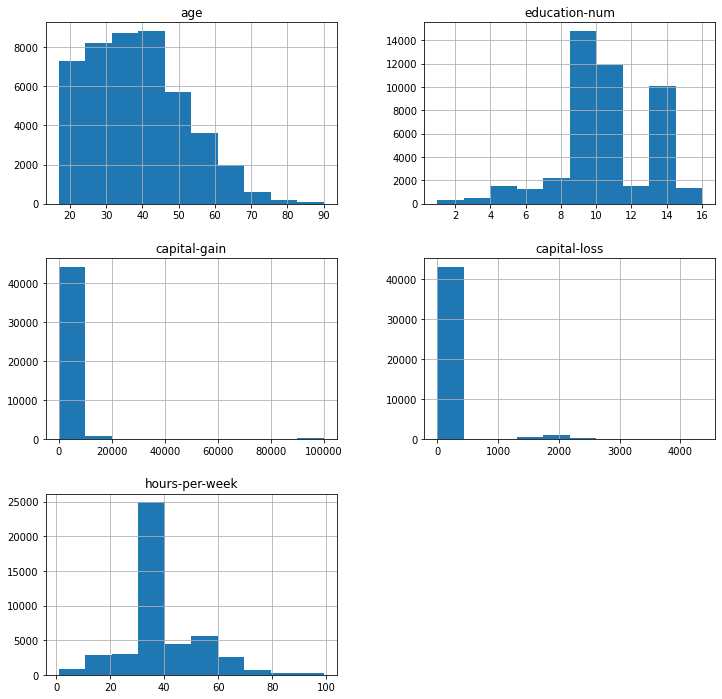

In [4]:
# plot histogram with 10 bins of all numeric features

_ = df.hist(figsize=(12,12))
plt.savefig('figures/hist.png')

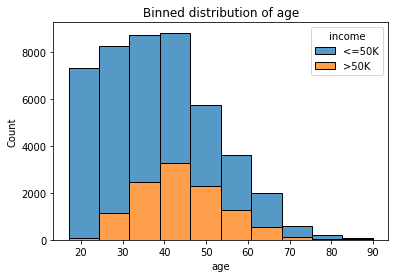

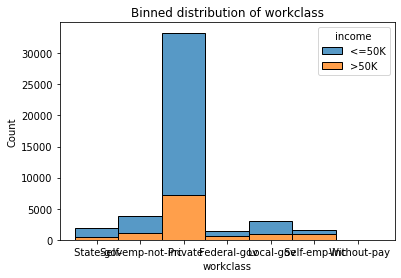

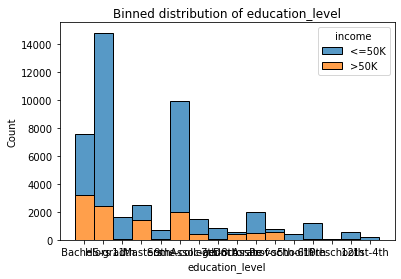

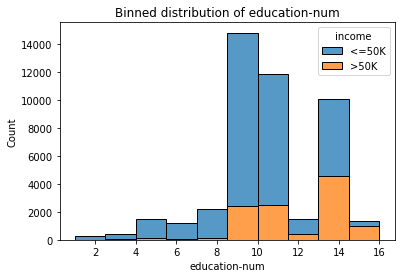

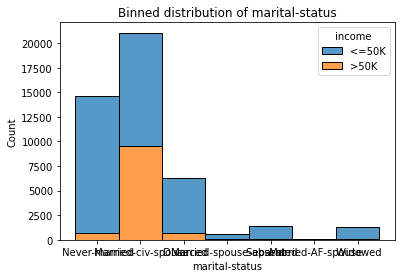

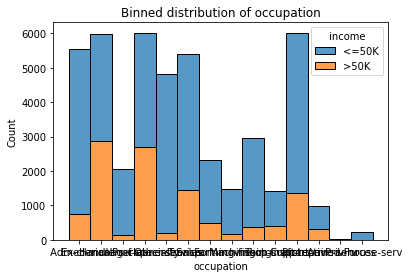

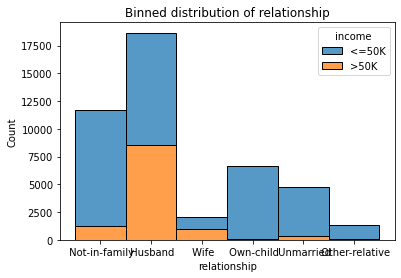

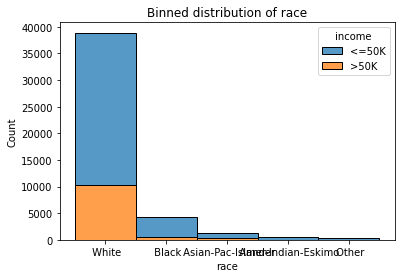

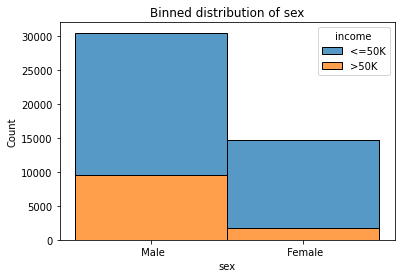

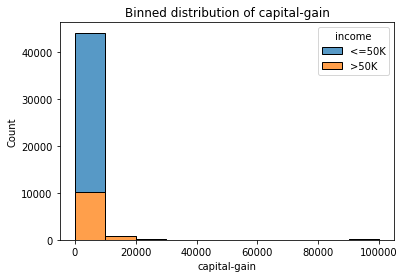

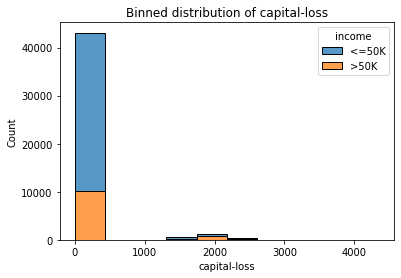

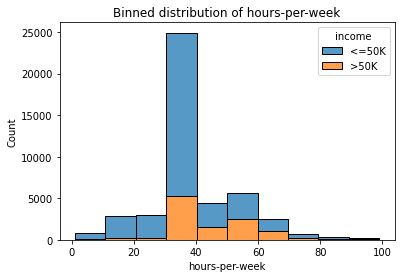

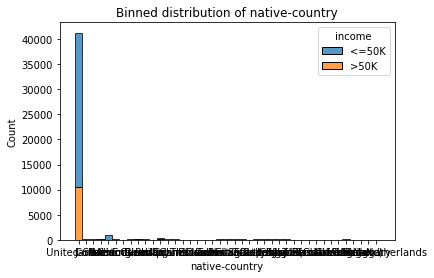

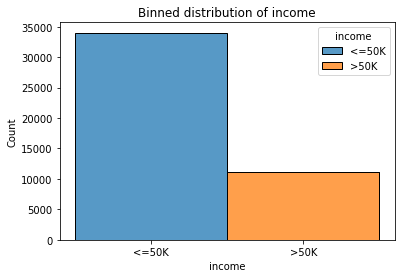

In [5]:
for elem in df.columns:
    sns.histplot(df, x=elem, hue="income", multiple="stack", bins=10);
    plt.title(f"Binned distribution of {elem}")
    plt.show()
    plt.close()

### label "income"

In [6]:
# number of records where individual's income is more than $50,000
n_greater_50k = len(df[df['income'] == '>50K'])

# number of records where individual's income is at most $50,000
n_at_most_50k = len(df[df['income'] == '<=50K'])

# percentage of individuals whose income is more than $50,000
n_records = len(df)
greater_percent = 100 * n_greater_50k / n_records


# Print the results
print (f"Total number of records:                {len(df)}")
print ("Individuals making more than $50,000:   {}".format(n_greater_50k))
print ("Individuals making at most $50,000:     {}".format(n_at_most_50k))
print("------------------------------------------------")
print ("Individuals making more than $50,000:      {:.2f}%".format(greater_percent))

Total number of records:                45222
Individuals making more than $50,000:   11208
Individuals making at most $50,000:     34014
------------------------------------------------
Individuals making more than $50,000:      24.78%


**Observations:** The dataset is imbalanced, by 25 to 75.

In [7]:
eda.describe_plus(df).T

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.00,45222.00,45222.00,45222.00,45222.00
mean,38.55,10.12,1101.43,88.60,40.94
std,13.22,2.55,7506.43,404.96,12.01
min,17.00,1.00,0.00,0.00,1.00
25%,28.00,9.00,0.00,0.00,40.00
50%,37.00,10.00,0.00,0.00,40.00
75%,47.00,13.00,0.00,0.00,45.00
max,90.00,16.00,99999.00,4356.00,99.00
skew,0.53,-0.31,11.79,4.52,0.34
kurtosis,-0.16,0.64,150.15,19.36,3.20


**Observations:** The columns "capital-gain" and "capital-loss" are skewed, they need to be processed.
## Preprocessing
### Transforming Skewed Continuous Features

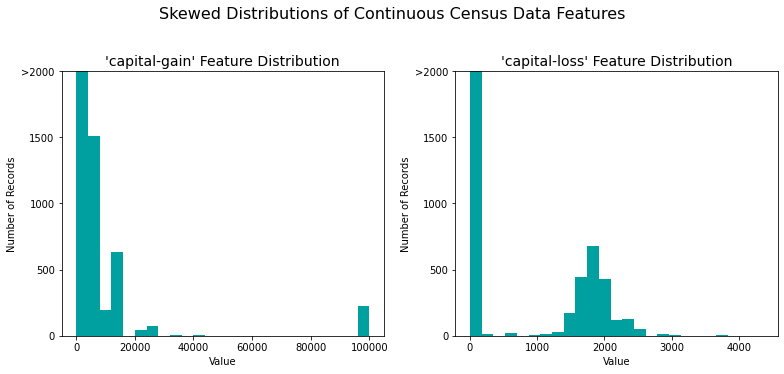

In [8]:
# Split the data into features and target label
label = df['income']
features = df.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(df)

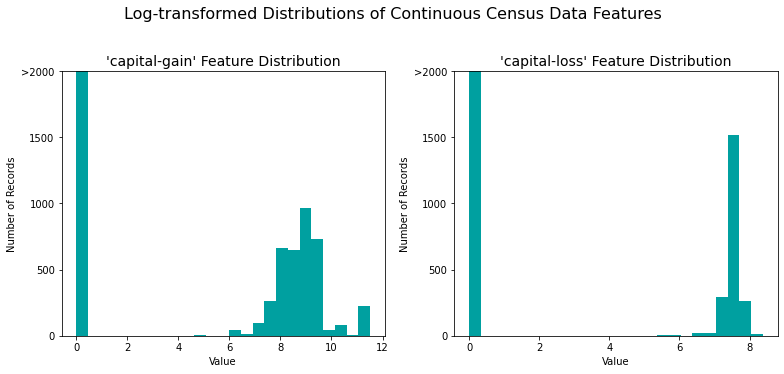

In [9]:
# logaritmize the skewed features
skewed = ['capital-gain', 'capital-loss']
features[skewed] = df[skewed].apply(lambda x: np.log(x + 1))

# visualize the new log distributions
vs.distribution(features, transformed = True)

### Normalizing numerical featrues

In [10]:
from sklearn.preprocessing import MinMaxScaler

# initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features[numerical] = scaler.fit_transform(df[numerical])

# show an example of a record with scaling applied
display(features.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Categorial to dummies

In [11]:
features = pd.get_dummies(features)

label = label.apply(lambda x: 1 if x == '>50K' else 0)
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))
print(features.shape)

103 total features after one-hot encoding.
(45222, 103)


### Shuffle and Split Data

Training set has 36177 samples.
Testing set has 9045 samples.
Training set has 36177 samples.
Testing set has 9045 samples.


,train abs,train %,test abs,test %,all abs,all %
0,27174,0.75,6840,0.76,34014,0.75
1,9003,0.25,2205,0.24,11208,0.25


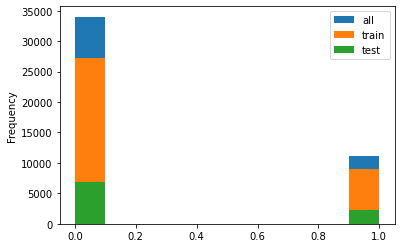

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state = 0)

print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

eda.plot_train_test_split(label,y_train,y_test)

## Evaluating Model Performance
### Metrics and the Naive Predictor

*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision.

Looking at the distribution of classes, it is clear most individuals do not make more than $50,000. This can greatly affect **accuracy**, since we could simply say "this person does not make more than \$50,000" and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Naive Predictor Performace

What if we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?

In [13]:
# calculate accuracy
accuracy = n_greater_50k / n_records

# calculating precision
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)

# calculating recall
recall = n_greater_50k / (n_greater_50k + 0)

# calculate F-score using the formula above for beta = 0.5
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

print ("Naive Predictor: \n Accuracy score: {:.3f} \n F-score:        {:.3f}".format(accuracy, fscore))

Naive Predictor: 
 Accuracy score: 0.248 
 F-score:        0.292


###  Model Application

**Logistic Regression**
 - Strengths: 
      - simple
      - outputs well-calibrated probabilities
      - used as a benchmark model to measure performance
 - Weaknesses:
     - over-fit on the training set
     - does not work well on high dimensions
     - non linear problems can't be solved

**KNN: K-Nearest Neighbors**
 - Strengths: 
      - no training period
      - data can be added seamlessly
      - simple to understand and interpret
 - Weaknesses:
     - does not work well on large datasets
     - need feature scaling
     - does not work well on high dimensions
     - sensitiv to noisy data
     
**Support Vector Machines (SVM)**

 - Strenghs: 
     - Effective in high dimensional spaces, or when there are a lot of features.
     - Kernel functions can be used to adapt to different cases, and can be completely customized if needed. Thus SVMs are versatile.
 - Weaknesses: 
     - Doesn't perform well with large datasets. 
     - Doesn't directly provide probability estimates.

**Decision Trees**

 - Strengths: 
      - Able to handle categorical and numerical data.
      - Doesn't require much data pre-processing, and can handle data which hasn't been normalized, or encoded for Machine Learning Suitability.
      - Simple to understand and interpret.
 - Weaknesses:
     - Complex Decision Trees do not generalize well to the data and can result in overfitting.
     - Unstable, as small variations in the data can result in a different decision tree. Hence they are usually used in an ensemble (like Random Forests) to build robustness.
     - Can create biased trees if some classes dominate.
     
**Ensamble method: Random Forest**

 - Strengths: 
      - Runtimes are quite fast, and they are able to deal with unbalanced and missing data.
      - Doesn't require much data pre-processing, and can handle data which hasn't been normalized, or encoded for Machine Learning Suitability.
      - Combines many "weak learners" to one "strong learner"
 - Weaknesses:
     - They may over-fit data sets that are particularly noisy

**Ensemble method: AdaBoost**

 - Strength: 
     - Ensemble methods, including Adaboost are more robust than single estimators, have improved generalizability. 
     - Simple models can be combined to build a complex model, which is computationally fast. 
 - Weaknesses:
     - If we have a biased underlying classifier, it will lead to a biased boosted model.

**Ensamble method: XGBoost**
 - Strength: 
     - Regularization: XGBoost has in-built L1 (Lasso Regression) and L2 (Ridge Regression) regularization which prevents the model from overfitting. That is why, XGBoost is also called regularized form of GBM (Gradient Boosting Machine).
     - Parallel Processing: XGBoost utilizes the power of parallel processing and that is why it is much faster than GBM. It uses multiple CPU cores to execute the model.
     - Handling Missing Values: XGBoost has an in-built capability to handle missing values. When XGBoost encounters a missing value at a node, it tries both the left and right hand split and learns the way leading to higher loss for each node. It then does the same when working on the testing data.
     - Cross Validation: XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run. This is unlike GBM where we have to run a grid-search and only a limited values can be tested.
     - Effective Tree Pruning: A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm. XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.

### Creating a Training and Predicting Pipeline

In [14]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: label training set
       - X_test: features testing set
       - y_test: label testing set
    '''    
    results = {}
    # fit the learner to the training data using slicing with 'sample_size'
    start = time()    # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time()      # Get end time    
    # calculate the training time
    results['train_time'] = end - start        
    # get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time()     # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()       # Get end time    
    # calculate the total prediction time
    results['pred_time'] = end - start           
    # compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)       
    # compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)    
    # compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)       
    # compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)       
    # success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    return results

### Model Evaluation

Let's train and test the models on training sets of different sizes to see how it affects their runtime and predictive performance.

In [15]:
# import supervised learning models from sklearn
# classifyer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# initialize the models
clf_A = LogisticRegression()
clf_B = KNeighborsClassifier()
clf_C = SVC()
clf_D = DecisionTreeClassifier()
clf_E = RandomForestClassifier()
clf_F = AdaBoostClassifier()
clf_G = XGBClassifier()


# calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E , clf_F, clf_G]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
KNeighborsClassifier trained on 362 samples.
KNeighborsClassifier trained on 3618 samples.
KNeighborsClassifier trained on 36177 samples.
SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.
DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.
XGBClassifier trained on 362 samples.
XGBClassifier trained on 3618 samples.
XGBClassifier trained on 36177 samples.


In [16]:
# printing the values
for i in results.items():
    print (i[0])
    display(round(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}),2))

LogisticRegression


,1%,10%,100%
train_time,0.01,0.06,0.57
pred_time,0.01,0.01,0.01
acc_train,0.85,0.84,0.85
acc_test,0.81,0.84,0.85
f_train,0.72,0.67,0.70
f_test,0.62,0.67,0.70


KNeighborsClassifier


,1%,10%,100%
train_time,0.00,0.02,0.99
pred_time,0.65,3.54,19.86
acc_train,0.87,0.86,0.87
acc_test,0.80,0.82,0.82
f_train,0.75,0.72,0.75
f_test,0.59,0.63,0.63


SVC


,1%,10%,100%
train_time,0.01,0.72,93.67
pred_time,0.20,1.43,21.04
acc_train,0.85,0.85,0.84
acc_test,0.81,0.83,0.84
f_train,0.71,0.70,0.69
f_test,0.61,0.65,0.67


DecisionTreeClassifier


,1%,10%,100%
train_time,0.00,0.02,0.28
pred_time,0.01,0.01,0.01
acc_train,1.00,1.00,0.97
acc_test,0.76,0.80,0.82
f_train,1.00,1.00,0.96
f_test,0.52,0.60,0.63


RandomForestClassifier


,1%,10%,100%
train_time,0.13,0.36,4.06
pred_time,0.09,0.13,0.22
acc_train,1.00,1.00,0.98
acc_test,0.82,0.84,0.84
f_train,1.00,1.00,0.97
f_test,0.63,0.67,0.68


AdaBoostClassifier


,1%,10%,100%
train_time,0.07,0.20,1.67
pred_time,0.10,0.11,0.14
acc_train,0.90,0.84,0.85
acc_test,0.81,0.85,0.86
f_train,0.81,0.68,0.71
f_test,0.61,0.70,0.72


XGBClassifier


,1%,10%,100%
train_time,0.17,0.52,4.98
pred_time,0.05,0.04,0.05
acc_train,1.00,0.94,0.89
acc_test,0.82,0.85,0.87
f_train,1.00,0.91,0.80
f_test,0.63,0.71,0.75


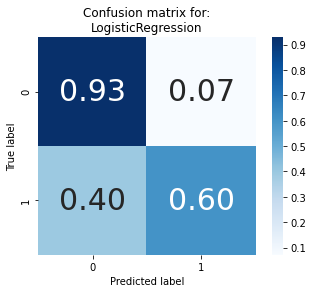

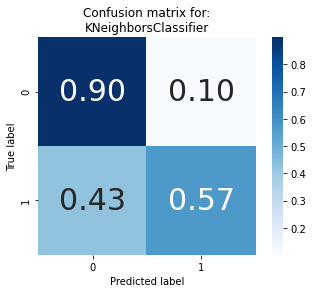

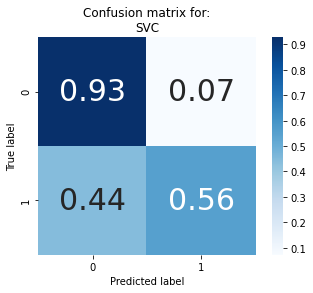

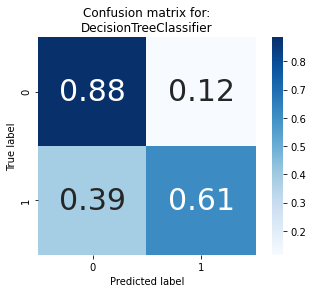

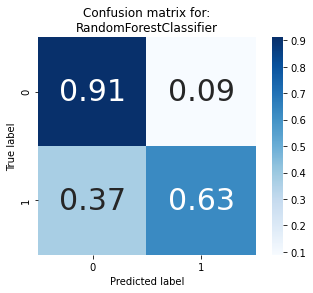

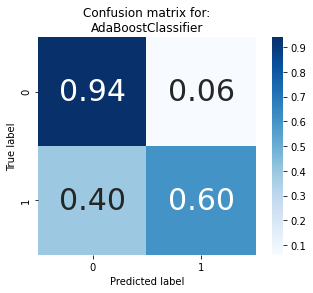

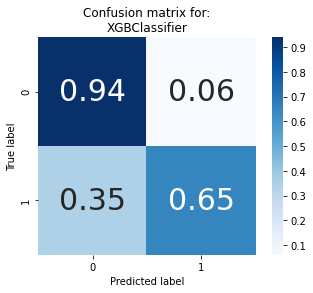

In [17]:
# visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C,clf_D,clf_E,clf_F,clf_G]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.2f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

Looking at the results above, out of the models, AdaBoost and XGBoost are the most appropriate for our task. First and foremost, these are the classifier that performs the best on the testing data, in terms of both the *accuracy* and *f-score*.  They also takes resonably low time to train on the full dataset, which is just a fraction of the 120 seconds taken by SVM, the next best classifier to train on the full training set. So it should scale well even if we have more data.

In [18]:
from sklearn.metrics import classification_report

# closer look AdaBoost and XGB
print("AdaBoost classification report \n")
print(classification_report(y_test, clf_F.predict(X_test)))
print("\n XGBoost classification report \n")
print(classification_report(y_test, clf_G.predict(X_test)))

AdaBoost classification report 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6840
           1       0.76      0.60      0.67      2205

    accuracy                           0.86      9045
   macro avg       0.82      0.77      0.79      9045
weighted avg       0.85      0.86      0.85      9045


 XGBoost classification report 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6840
           1       0.78      0.65      0.71      2205

    accuracy                           0.87      9045
   macro avg       0.84      0.80      0.81      9045
weighted avg       0.87      0.87      0.87      9045



## Tuning our models
### AdaBoost

**Explanation:** Whats is AdaBoost?

The AdaBoost algorithm is part of the family of boosting algorithms and was first introduced by Freund & Schapire in 1996. It is sequentially growing decision trees as weak learners and punishing incorrectly predicted samples by assigning a larger weight to them after each round of prediction. This way, the algorithm is learning from previous mistakes. The final prediction is the weighted majority vote (or weighted median in case of regression problems).
For t in T rounds:
- Calculate distribution p by normalizing the weight vector w (the initial weights in w for the first round are 1/N, where N represents the number of labeled examples)
- Grow a weak learner (decision tree) using the distribution p; return hypothesis h with prediction values for each example
- Calculate error term ε of h
- Assign β with ε/(1- ε)
- Update the weight vector to w = w*β so that predictions with poor performance will have higher a weight and predictions with better performance will have a lower weight

Output: final hypothesis is the result of a weighted majority vote of all T weak learners

There are certain advantages and disadvantages inherent to the AdaBoost algorithm. AdaBoost is relatively robust to overfitting in low noise datasets (refer to Rätsch et al. (2001)). AdaBoost has only a few hyperparameters that need to be tuned to improve model performance. Moreover, this algorithm is easy to understand and to visualize. However, for noisy data the performance of AdaBoost is debated with some arguing that it generalizes well, while others show that noisy data leads to poor performance due to the algorithm spending too much time on learning extreme cases and skewing results. Compared to random forests and XGBoost, AdaBoost performs worse when irrelevant features are included in the model as shown by my time series analysis of bike sharing demand. Moreover, AdaBoost is not optimized for speed, therefore being significantly slower than XGBoost.

The relevant hyperparameters to tune are limited to the maximum depth of the weak learners/decision trees, the learning rate and the number of iterations/rounds. The learning rate balances the influence of each decision tree on the overall algorithm, while the maximum depth ensures that samples are not memorized, but that the model will generalize well with new data.
The above information shows that AdaBoost is best used in a dataset with low noise, when computational complexity or timeliness of results is not a main concern and when there are not enough resources for broader hyperparameter tuning due to lack of time and knowledge of the user.

In [21]:
from sklearn.model_selection import RandomizedSearchCV

clf_ada = AdaBoostClassifier()
parameters = {'n_estimators': [50, 100, 200, 500, 1000, 1500, 2000],
              'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1.0]}

clf_ada = RandomizedSearchCV(clf_ada,
                             param_distributions=parameters,
                             scoring='f1',
                             cv=5,
                             n_iter=10,
                             verbose=1,
                             n_jobs=-1)

ada_fit = clf_ada.fit(X_train, y_train)

clf_ada_best_score = clf_ada.best_score_
clf_ada_best_params = clf_ada.best_params_
print("Best score: {}".format(clf_ada_best_score))
print("Best params: ")
for param_name in sorted(clf_ada_best_params.keys()):
    print('%s: %r' % (param_name, clf_ada_best_params[param_name]))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.1min finished


Best score: 0.7112839665313634
Best params: 
learning_rate: 1.0
n_estimators: 1000


In [22]:
# best params for optimized model
opt_ada = AdaBoostClassifier(learning_rate=1,n_estimators=1000)

opt_ada.fit(X_train,y_train)

opt_ada_pred_train = opt_ada.predict(X_train)
opt_ada_pred_test = opt_ada.predict(X_test)

print("opt AdaBoost on training data \n")
print(classification_report(y_train, opt_ada_pred_train))
print(confusion_matrix(y_train, opt_ada_pred_train))
print("\n opt AdaBoost on test data \n")
print(classification_report(y_test, opt_ada_pred_test))
print(confusion_matrix(y_test, opt_ada_pred_test))

opt AdaBoost on training data 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     27174
           1       0.79      0.66      0.72      9003

    accuracy                           0.87     36177
   macro avg       0.84      0.80      0.82     36177
weighted avg       0.87      0.87      0.87     36177

[[25563  1611]
 [ 3071  5932]]

 opt AdaBoost on test data 

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6840
           1       0.78      0.64      0.70      2205

    accuracy                           0.87      9045
   macro avg       0.83      0.79      0.81      9045
weighted avg       0.86      0.87      0.86      9045

[[6430  410]
 [ 788 1417]]


### XGBoost

**Explanation:** Whats is XGBoost?

XGBoost (eXtreme Gradient Boosting) is a relatively new algorithm that was introduced by Chen & Guestrin in 2016 and is utilizing the concept of gradient tree boosting. XGBoost was developed to increase speed and performance, while introducing regularization parameters to reduce overfitting. Gradient boosted trees use regression trees (or CART) in a sequential learning process as weak learners. These regression trees are similar to decision trees, however, they use a continuous score assigned to each leaf (i.e. the last node once the tree has finished growing) which is summed up and provides the final prediction. For each iteration i which grows a tree t, scores w are calculated which predict a certain outcome y. The learning process aims to minimize the overall score which is composed of the loss function at i-1 and the new tree structure of t. This allows the algorithm to sequentially grow the trees and learn from previous iterations. Gradient descent is then used to compute the optimal values for each leaf and the overall score of tree t. The score is also called the impurity of the predictions of a tree.

The loss function in the above algorithm contains a regularization or penalty term Ω whose goal it is to reduce the complexity of the regression tree functions. This parameter can be tuned and can take values equal or greater than 0. If it is set to 0, then there is no difference between the prediction results of gradient boosted trees and XGBoost. In addition, Chen & Guestrin introduce shrinkage (i.e. a learning rate) and column subsampling (randomly selecting a subset of features) to this gradient tree boosting algorithm which allows further reduction of overfitting. It therefore adds the methods to handle overfitting introduced in AdaBoost (the learning rate) and random forests (column or feature subsampling) to the regularization parameter found in stochastic gradient descent models.

The main advantages of XGBoost is its lightning speed compared to other algorithms, such as AdaBoost, and its regularization parameter that successfully reduces variance. But even aside from the regularization parameter, this algorithm leverages a learning rate (shrinkage) and subsamples from the features like random forests, which increases its ability to generalize even further. However, XGBoost is more difficult to understand, visualize and to tune compared to AdaBoost and random forests. There is a multitude of hyperparameters that can be tuned to increase performance.

To name a few of the relevant hyperparameters: the learning rate, column subsampling and regularization rate were already mentioned. Additionally, subsample (which is bootstrapping the training sample), maximum depth of trees, minimum weights in child notes for splitting and number of estimators (trees) are also frequently used to address the bias-variance-trade-off. While higher values for the number of estimators, regularization and weights in child notes are associated with decreased overfitting, the learning rate, maximum depth, subsampling and column subsampling need to have lower values to achieve reduced overfitting. Yet, extreme values will lead to underfitting of the model.

In [23]:
from scipy import stats
from scipy.stats import randint

clf_xgb = XGBClassifier()

param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
              }

clf_xgb = RandomizedSearchCV(clf_xgb,
                             param_distributions=param_dist,
                             cv=5,
                             n_iter=20,
                             scoring='f1',
                             error_score=0,
                             verbose=1,
                             n_jobs=-1)

clf_xgb.fit(X_train, y_train)

clf_xgb_best_score = clf_xgb.best_score_
clf_xgb_best_params = clf_xgb.best_params_
print("Best score: {}".format(clf_xgb_best_score))
print("Best params: ")
for param_name in sorted(clf_xgb_best_params.keys()):
    print('%s: %r' % (param_name, clf_xgb_best_params[param_name]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.7min finished


Best score: 0.7176761179383278
Best params: 
learning_rate: 0.2306010225490029
max_depth: 4
n_estimators: 380


In [24]:
# best params for optimized model
opt_xgb = XGBClassifier(learning_rate=0.38332977608526675, max_depth=3, n_estimators=233)
opt_xgb.fit(X_train,y_train)

opt_xgb_pred_train = opt_xgb.predict(X_train)
opt_xgb_pred_test = opt_xgb.predict(X_test)

print("opt XGBoost on train data \n")
print(classification_report(y_train, opt_xgb_pred_train))
print(confusion_matrix(y_train,opt_xgb_pred_train))
print("\n opt XGBoost on test data \n")
print(classification_report(y_test, opt_xgb_pred_test))
print(confusion_matrix(y_test, opt_xgb_pred_test))

opt XGBoost on train data 

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     27174
           1       0.81      0.69      0.74      9003

    accuracy                           0.88     36177
   macro avg       0.85      0.82      0.83     36177
weighted avg       0.88      0.88      0.88     36177

[[25684  1490]
 [ 2818  6185]]

 opt XGBoost on test data 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6840
           1       0.78      0.66      0.71      2205

    accuracy                           0.87      9045
   macro avg       0.84      0.80      0.82      9045
weighted avg       0.87      0.87      0.87      9045

[[6431  409]
 [ 756 1449]]


### Final Model Evaluation
#### Results: Naive predictor

In [25]:
print ("Naive Predictor: \n Accuracy score: {:.3f} \n F-score:        {:.3f}".format(accuracy, fscore))

Naive Predictor: 
 Accuracy score: 0.248 
 F-score:        0.292


#### Results: AdaBoost

In [26]:
print("AdaBoost classification report \n")
print(classification_report(y_test, clf_F.predict(X_test)))
print("\n opt AdaBoost on test data \n")
print(classification_report(y_test, opt_ada_pred_test))
print(confusion_matrix(y_test, opt_ada_pred_test))

AdaBoost classification report 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6840
           1       0.76      0.60      0.67      2205

    accuracy                           0.86      9045
   macro avg       0.82      0.77      0.79      9045
weighted avg       0.85      0.86      0.85      9045


 opt AdaBoost on test data 

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6840
           1       0.78      0.64      0.70      2205

    accuracy                           0.87      9045
   macro avg       0.83      0.79      0.81      9045
weighted avg       0.86      0.87      0.86      9045

[[6430  410]
 [ 788 1417]]


**Observation:** The optimization had very little impact. Just the accuracy increased by 0.01.

#### Results: XGBoost

In [27]:
print("XGBoost classification report \n")
print(classification_report(y_test, clf_G.predict(X_test)))
print("\n opt XGBoost on test data \n")
print(classification_report(y_test, opt_xgb_pred_test))
print(confusion_matrix(y_test, opt_xgb_pred_test))

XGBoost classification report 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6840
           1       0.78      0.65      0.71      2205

    accuracy                           0.87      9045
   macro avg       0.84      0.80      0.81      9045
weighted avg       0.87      0.87      0.87      9045


 opt XGBoost on test data 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6840
           1       0.78      0.66      0.71      2205

    accuracy                           0.87      9045
   macro avg       0.84      0.80      0.82      9045
weighted avg       0.87      0.87      0.87      9045

[[6431  409]
 [ 756 1449]]


**Observation:** The optimization had no impact.

# Conclusion

In this notebook I was able to prove the strengths and weaknesses of different ML methods for classification using a real-life data set. In addition to the running time, it was also important how the individual methods perform on parts of the data set. This could become important if the data sets become larger and we need to split them or train on a sample. The RandomSearchCV already showed that I had to wait a long time. If I had used only a part of the data (about 10% or even 50%) this would have been much faster. Nevertheless, in the end two very good models were created. The AdaBoost and the XGBoost have proven to be very effective and are ready to be used by the charities of the world after hyper parameter tuning.

Concluding remarks on the models:
- Although the logistic regression was one of the faster models, the scores (Accuracy 0.85, F1 0.70) are not bad. It also shows that the method would be usable even with 10% of the sample size.
- As expected, the KNN has a longer training time (19.62) and is also subject to logistic regression in the results (Accuracy 0.82, F1 0.63). The sample size is similar to the logistic regression.
- The SVC has by far the longest training time (>1min), with the pred_time it is equal to the KNN. In addition, the results with (Accuracy 0.84, F1 0.67) are modest.
- The Desicion Tree clearly shows the problem of overfitting in training, even with fantastic values (Accuracy 0.97, F1 0.96), it worsens when tested for an Accuracy of 0.82 and an F1 of 0.63. Not surprisingly, but clearly the weakness of the method is evident here.
- The random forest has a short pred_time of 0.23. Moreover, the values of 0.84 accuracy and 0.68 F1 are good, but other models are better.
- The AdaBoost already had an accuracy of 0.86 and an F1 score of 0.72 in the baseline model, which put it just ahead of the random forest and was only exceeded by one model.
- The XGBoost had a long training time of 5.14 but also the best scores (Accuracy 0.87, F1 0.75).